In [38]:
import pandas as pd
import numpy as numpy
import faiss
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
mat = numpy.load('filtered_wordvecs.npy')

In [40]:
mat[0:100,]

array([[  1.52343750e-01,  -1.21093750e-01,   1.02050781e-01, ...,
          1.37939453e-02,  -5.73730469e-02,   2.77343750e-01],
       [ -7.03125000e-02,   1.40380859e-03,  -1.25000000e-01, ...,
         -5.71289062e-02,   1.39160156e-02,  -1.53808594e-02],
       [  2.40325928e-04,   1.66320801e-03,  -2.44140625e-02, ...,
         -6.64062500e-02,  -4.12597656e-02,   1.48437500e-01],
       ..., 
       [  1.62109375e-01,   1.81640625e-01,  -6.20117188e-02, ...,
         -9.32617188e-02,   7.08007812e-02,  -8.25195312e-02],
       [  2.44140625e-02,  -4.17480469e-02,  -5.29785156e-02, ...,
         -1.50146484e-02,   2.24609375e-02,   1.33056641e-02],
       [  3.22265625e-01,  -1.09375000e-01,  -4.02343750e-01, ...,
          1.18652344e-01,   1.10351562e-01,   2.39257812e-01]])

In [41]:
words = pd.read_csv('vocabulary.txt')

In [42]:
words.columns = ['idf']

In [43]:
words.head(3)

,idf
0,0ER
1,0S
2,0s


In [44]:
def MyDBSCAN(D, eps, MinPts,method):
    """
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    MyDBSCAN takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    """
 
    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #     0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for P in range(0, len(D)):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
           continue
        
        # Find all of P's neighboring points.
        NeighborPts = regionQuery(D, P, eps,method,index)
        ###################################################################################
        # If the number is below MinPts, this point is noise. 
        # This is the only condition under which a point is labeled 
        # NOISE--when it's not a valid seed point. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           growCluster(D, labels, P, NeighborPts, C, eps, MinPts,method)
    
    # All data has been clustered!
    return labels


In [45]:
def growCluster(D, labels, P, NeighborPts, C, eps, MinPts,method):
    """
    Grow a new cluster with label `C` from the seed point `P`.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
    
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    """

    # Assign the cluster label to the seed point.
    labels[P] = C
    
    # Look at each neighbor of P (neighbors are referred to as Pn). 
    # NeighborPts will be used as a FIFO queue of points to search--that is, it
    # will grow as we discover new branch points for the cluster. The FIFO
    # behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
           labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = regionQuery(D, Pn, eps,method)
            
            # If Pn has at least MinPts neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched. 
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
            # Don't queue up it's neighbors as expansion points.
            #else:
                # Do nothing                
                #NeighborPts = NeighborPts               
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!



In [46]:
def regionQuery(D, P, eps,method):
    """
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    """
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if method == 1:
            
            if numpy.linalg.norm(D[P] - D[Pn]) < eps:
               neighbors.append(Pn)
            
    return neighbors

In [47]:
%timeit new_labels_100 = MyDBSCAN(mat[0:100,],eps=1,MinPts=2,method=1)

10 loops, best of 3: 40.1 ms per loop


In [48]:
#If I take 10000 data points, it takes forever to run
import timeit
results = {}
time_df = pd.DataFrame(columns = ['num_points','eps','time_taken'])
i = 0
for num_points in [100,1000]:
    for eps in [0.01,0.1,0.2,0.5,0.7,1,2,5,7,10,20,50,70,100]:
        start_time = timeit.default_timer()
        results['{}'.format(i)] = MyDBSCAN(mat[0:num_points,],eps=eps,MinPts=2, method =1)
        time_taken = timeit.default_timer() - start_time
        time_df = time_df.append({"num_points": num_points,"eps": eps, "time_taken":time_taken }, ignore_index=True)
        i = i +1

In [49]:
time_df

,num_points,eps,time_taken
0,100.0,0.01,0.048771
1,100.0,0.10,0.044729
2,100.0,0.20,0.039506
3,100.0,0.50,0.038775
4,100.0,0.70,0.038763
5,100.0,1.00,0.043771
6,100.0,2.00,0.045126
7,100.0,5.00,0.043366
8,100.0,7.00,0.041805
9,100.0,10.00,0.041279


In [50]:
import seaborn as sns
%matplotlib inline

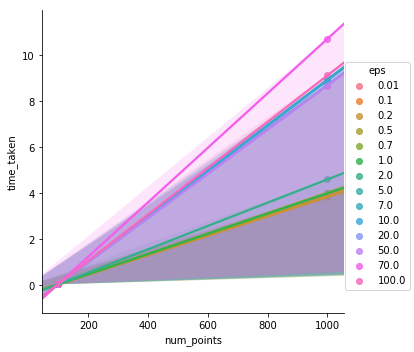

In [51]:
sns.lmplot(x="num_points", y="time_taken", hue="eps", data=time_df)

In [ ]:
# In a nutshell above is the graph which shows how time taken linearly increases with the number of points. 
# Also, gettting the optimal eps is somewhat tedious as far as dbscan is concerned.

In [52]:
#The next part will explore FAISS to run the similarity of same data points

In [60]:
# Example given in the documentation

In [65]:
# For the sake of our case, the xb will be all the word vectors, or for the sake of simplicity can be the first 100,
# 1000, or 10000 vectors as per our experimental needs
# d which represents the dimension of the vectors will be 300
# Faiss uses only 32-bit floating point matrices
import faiss                   # make faiss available

In [66]:
d = 300
xb = mat[0:100,].astype('float32')
xq = mat[0:100,].astype('float32')


In [67]:
#Building an index and adding the vectors to it
start_time = timeit.default_timer()
index = faiss.IndexFlatL2(d)   # build the index
print index.is_trained
index.add(xb)                  # add vectors to the index
print index.ntotal
time_taken = timeit.default_timer() - start_time
print time_taken

True
100
0.0173690319061


In [68]:
#Searching

In [69]:
# We will find the 4 nearest neighbors for these vectors
k = 4                          # we want to see 4 nearest neighbors
start_time = timeit.default_timer()
D, I = index.search(xb[:5], k) # sanity check
time_taken = timeit.default_timer() - start_time
print time_taken
print I
print D

0.0141949653625
[[ 0 26 40 14]
 [ 1 79 22 52]
 [ 2 79 22 63]
 [ 3 22 11 79]
 [ 4 14 26 40]]
[[  0.           7.63688564   7.93695307   8.06742764]
 [  0.           0.87420905   1.06439281   1.29742646]
 [  0.           1.90855575   1.97302008   2.0938282 ]
 [  0.          14.46333504  14.56112194  14.62785912]
 [  0.           0.6771577    0.97074127   1.04108286]]


In [70]:
#the nearest neighbor of each query is indeed the index of the vector, and the corresponding distance is 0.
# For the first point the nearest neighbor has and index of 26, the next nearest is 40 and the next is 14
# The corresponding approximate distances are mentioned in the array below.

In [72]:
start_time = timeit.default_timer()
D, I = index.search(xq, k)     # actual search
print I[:5]                    # neighbors of the 5 first queries
print I[-5:]  
time_taken = timeit.default_timer() - start_time
print time_taken

[[ 0 26 40 14]
 [ 1 79 22 52]
 [ 2 79 22 63]
 [ 3 22 11 79]
 [ 4 14 26 40]]
[[95 91 98 96]
 [96 98 91  8]
 [97  8 98 94]
 [98  8 91 94]
 [99 98  8 63]]
0.250288963318


In [73]:
# Clearly doesnt take much once the index has been created.

In [75]:
I[0]

array([ 0, 26, 40, 14])

In [76]:
#I[0] gives the five nearest neighbors 

In [84]:
D[0]

array([ 0.        ,  7.6368866 ,  7.93695498,  8.06742954], dtype=float32)

In [85]:
# D[0] gives the distances for the nearest points including the point itself

In [87]:
D[0][1]

7.6368866

In [88]:
# we do have a dummy distance. We now need to implement a dbscan. 
# D remains the dataset


In [ ]:
# Based on this investigation, it seems that the dummy distances are pre calculated and hence there is meaning of 
# writing getting the distance all over again.